## Problem description

Predict the price of flat in Wurzbrug based on its size (in sqm) and time since last renovation (in yrs).

* input: $\mathbf{x} \in \mathbb{R}^2$, each example $\mathbf{x}$ consists of 2 features
* output: $y \in \mathbb{R}$, single output (price)
* Thus the dataset matrix = $\mathbf{X} \in \mathbb{R}^{x \times 2}$

In [1]:
# import torch
# --- YOUR CODE HERE ---
import torch
import random
from matplotlib import pyplot as plt

### Generate synthetic data

Generate some data which are a bit similar to reality:

* sizes from normal distribution with mean 70 and std 20
* years from normal distribution with mean 5 and std 2
* clamp the input data into reasonable values (e.g. sizes btw $[20, 150]$, years btw $[0, 10]$)

In [13]:
# Fix number of data examples (e.g. to 1000)
# --- YOUR CODE HERE ---
num_samples = 1000

# generate random input data
# --- YOUR CODE HERE ---
sizes = torch.normal(mean=70, std=20, size=(num_samples, 1))
years = torch.normal(mean=5, std=2, size=(num_samples, 1))

sizes = torch.clamp(sizes, min=20, max=150)
years = torch.clamp(years, min=0, max=10)

# make sure the inputs are a single tensor with 2 colums
# --- YOUR CODE HERE ---
features = torch.cat((sizes, years),1)
features.shape

torch.Size([1000, 2])

### Generate synthetic labels

We are working with liner model so assume labels are generated as $y = \mathbf{x}^T \mathbf{w} + b + e$, where $e$ is random gaussian noise.

Fix true parameters to the following values:

* weight for size = 10.
* weight for years = -20.
* bias = 100
* random noise is Gaussian with mean 0. and standard deviation 5.

In [17]:
# fix true parameters for the linear regression
# --- YOUR CODE HERE ---
true_w = torch.tensor([10.0, -20.0])

# bias
# --- YOUR CODE HERE ---
true_b = 100.0

# generate outputs from linear regression model y = x^T w + b + e
# --- YOUR CODE HERE ---
labels = torch.matmul(features, true_w) + true_b
labels += torch.normal(mean=0, std=5, size=labels.shape) #noise e
labels = labels.reshape((-1, 1))
labels

tensor([[ 631.3220],
        [ 473.5227],
        [ 553.6929],
        [ 982.2723],
        [ 584.4164],
        [ 656.4320],
        [ 926.3043],
        [1051.9961],
        [ 259.8166],
        [ 588.7101],
        [ 724.6099],
        [ 543.5127],
        [ 775.0923],
        [ 586.9254],
        [ 522.3340],
        [ 579.1983],
        [ 781.4257],
        [ 922.0909],
        [1103.7242],
        [1052.6836],
        [ 688.6729],
        [ 689.5379],
        [ 952.7027],
        [ 889.2498],
        [ 530.2220],
        [ 827.2535],
        [1131.9955],
        [ 994.9871],
        [ 649.1763],
        [ 387.4852],
        [ 684.2958],
        [ 921.6703],
        [ 477.7242],
        [ 124.8461],
        [1020.3958],
        [ 731.2220],
        [ 589.5135],
        [ 627.5419],
        [ 867.7413],
        [ 657.6680],
        [ 561.2000],
        [ 706.8572],
        [ 658.0724],
        [ 491.6157],
        [ 687.5854],
        [ 792.3555],
        [ 767.4014],
        [ 350

### Plot data

Use matplotlib library to plot a scatter graph of price against the size of the apartment

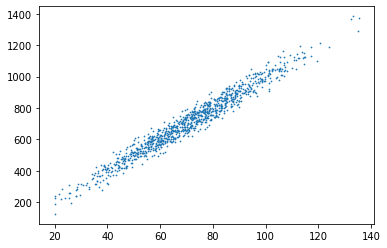

In [18]:
# use matplilib to plot a scatter of price against the size
# --- YOUR CODE HERE ---
from matplotlib import pyplot as plt
%matplotlib inline
plt.scatter(sizes.detach().numpy(), labels.detach().numpy(), .5) # detach tensor graphs and convert to ndarray

### Data loading

Write a generator to load batches of data. It shall recieve as arguments the data inputs, outputs and the batch size and yield a batch of examples at every call, where batch is a tuple of inputs and outputs in the batch. Remember to shuffle the data at the initiation of the generator so that you do not get always the same batches.

- iterator: Iterates over a list
- generator: Generates a list

- *param*: inputs, outputs, batch_size
- *yield*: batch (inputs, outputs)


- range: 
- - start: Starting number of the sequence.
- - stop: Generate numbers up to, but not including this number.
- - step: Difference between each number in the sequence.


- min:
- - return the lowest number of an iterable

In [39]:
# define a function (generator) iter_data(inputs, outputs, batch_size) -> (batch_inputs, batch_outputs)
# --- YOUR CODE HERE ---
import random

def generator(features, labels, batch_size):
    num_examples = len(features) # just assign lenght of our input to a variable
    indices = list(range(num_examples)) # create a list of indices with respect to the number of examples (0,1,...,999)
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size): # with batch_size 10 -> i=0, i=10, i=20, ... i=990
        # define range of batch
        # with batch_size 10 & num_examples 1000 
            # (0 + 10, 1000) = 10, (10 + 10, 1000) = 20, ..., (1000 + 10, 1000) = 1000 
        end = min(i + batch_size, num_examples)

        # create a tensor out of the list with indices from the examples
        batch_indices = torch.tensor(indices[i:end]) 
        yield features[batch_indices], labels[batch_indices]


### Iterate through data

Check your generator works by iterating once through all the data and printing out the batch at every iteration.

### Model definition

We work with linear regression so we need to define a linear regression model as $\hat{y} = \mathbf{x}^T \mathbf{w} + b$.
Here $\mathbf{w}$ and $b$ are the unknown parameters that we need to learn.

In [40]:
# define a function lin_reg(inputs, weight, bias) -> y_hat 
# --- YOUR CODE HERE ---
def lin_reg(features, weights, bias):
    return torch.matmul(features, weights) + bias

### Loss function definition

We use squared error loss function $$\mathcal{L} = \frac{1}{n} \sum_{i = 1}^{n} \frac{1}{2}(\hat{y}^{(i)} - y^{(i)})^2$$

In [41]:
# define a function loss_func(labels, preds) -> error
# --- YOUR CODE HERE ---
def mse_loss(y, y_pred):
    return ((y - y_pred)**2).mean()

### Optimization algorithm

We will use minibatch stochastic gradient descent to update the parameters. The function should update the parameter values by a small step opposite to the gradient direction (which indicates the steepest increase). $\mathbf{w} \leftarrow \mathbf{w} - \alpha \nabla_w$

In [42]:
# define a function sgd_step(params, learn_rate, batch_size) that does one step in the gradient updates
# --- YOUR CODE HERE ---
def sgd(params, learn_rate, batch_size):
    for param in params:
        with torch.no_grad():
            param -= param.grad * learn_rate / batch_size
            param.grad.zero_()

### Model training

After all the pieces are ready, we implemen the main training loop. It needs to do the following:

* initiate randomly the linear model parameters $(\mathbf{w}, b)$
* repeat for each epoch (unitl done)
    * load batch of data
    * do linear model precitions with current parameter values
    * calculate loss
    * get gradients
    * update parameter values

In [102]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [103]:
epochs = 10
batch_size = 10
learning_rate = 0.03

In [50]:
# write the training procedure
# --- YOUR CODE HERE ---
for epoch in range(epochs):
    for X, y in generator(features, labels, batch_size):
        y_pred = lin_reg(X, w, b)
        batch_loss = mse_loss(y, y_pred)
        print(batch_loss)
        batch_loss.sum().backward()
        print(batch_loss)
        sgd([w, b], learning_rate, batch_size)

tensor(541030.0625, grad_fn=<MeanBackward0>)
tensor(541030.0625, grad_fn=<MeanBackward0>)
tensor(6.9004e+08, grad_fn=<MeanBackward0>)
tensor(6.9004e+08, grad_fn=<MeanBackward0>)
tensor(9.8696e+11, grad_fn=<MeanBackward0>)
tensor(9.8696e+11, grad_fn=<MeanBackward0>)
tensor(1.1498e+15, grad_fn=<MeanBackward0>)
tensor(1.1498e+15, grad_fn=<MeanBackward0>)
tensor(8.2693e+17, grad_fn=<MeanBackward0>)
tensor(8.2693e+17, grad_fn=<MeanBackward0>)
tensor(6.8547e+20, grad_fn=<MeanBackward0>)
tensor(6.8547e+20, grad_fn=<MeanBackward0>)
tensor(8.4721e+23, grad_fn=<MeanBackward0>)
tensor(8.4721e+23, grad_fn=<MeanBackward0>)
tensor(7.2508e+26, grad_fn=<MeanBackward0>)
tensor(7.2508e+26, grad_fn=<MeanBackward0>)
tensor(5.4615e+29, grad_fn=<MeanBackward0>)
tensor(5.4615e+29, grad_fn=<MeanBackward0>)
tensor(5.7775e+32, grad_fn=<MeanBackward0>)
tensor(5.7775e+32, grad_fn=<MeanBackward0>)
tensor(9.2552e+35, grad_fn=<MeanBackward0>)
tensor(9.2552e+35, grad_fn=<MeanBackward0>)
tensor(inf, grad_fn=<MeanBackw

tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
t

tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
tensor(nan, grad_fn=<MeanBackward0>)
t

### Normalize imput data

It is usually better to normalize your input data to remove any scaling differences. The normalized data shall have zero mean $\mu$ and standard deviation $\sigma$ 1.
$$x_{norm} = \frac{x - \mu(x)}{\sigma(x)}$$

In [100]:
### Normalize input data so that each input dimension has mean = 0 and std = 1
# --- YOUR CODE HERE ---

# sizes
mean = sizes.mean()
std = sizes.std()
sizes_norm = (sizes - mean) / std

# years
mean = years.mean()
std = years.std()
years_norm = (years - mean) / std

features_norm = torch.cat((sizes_norm, years_norm), 1)
print(features_norm)

tensor([[-0.7995, -1.9468],
        [-1.0381,  1.0181],
        [-0.5329,  1.4622],
        ...,
        [ 0.8289, -1.5137],
        [ 0.7413, -0.1873],
        [ 0.5284,  0.6324]])


### Plot data again

Just to check the result of the normalization step, plot again the scatter of price agains the normalized size.

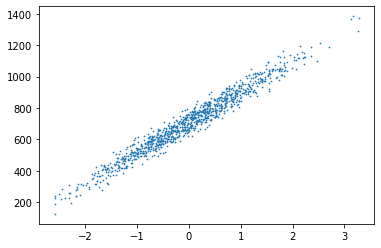

In [97]:
# --- YOUR CODE HERE ---
plt.scatter(sizes_norm.detach().numpy(), labels.detach().numpy(), .5)

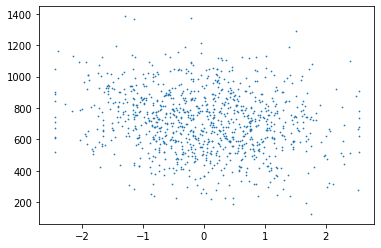

In [101]:
plt.scatter(years_norm.detach().numpy(), labels.detach().numpy(), .5)

### Train over normalized data

In [104]:
# --- YOUR CODE HERE ---
for epoch in range(epochs):
    for X, y in generator(features_norm, labels, batch_size):
        y_pred = lin_reg(X, w, b)
        batch_loss = mse_loss(y, y_pred)
        print(batch_loss)
        batch_loss.sum().backward()
        print(batch_loss)
        sgd([w, b], learning_rate, batch_size)

tensor(383094.5000, grad_fn=<MeanBackward0>)
tensor(383094.5000, grad_fn=<MeanBackward0>)
tensor(516869.0625, grad_fn=<MeanBackward0>)
tensor(516869.0625, grad_fn=<MeanBackward0>)
tensor(593342.6875, grad_fn=<MeanBackward0>)
tensor(593342.6875, grad_fn=<MeanBackward0>)
tensor(551971.8750, grad_fn=<MeanBackward0>)
tensor(551971.8750, grad_fn=<MeanBackward0>)
tensor(522294.5000, grad_fn=<MeanBackward0>)
tensor(522294.5000, grad_fn=<MeanBackward0>)
tensor(452081.0938, grad_fn=<MeanBackward0>)
tensor(452081.0938, grad_fn=<MeanBackward0>)
tensor(539071.4375, grad_fn=<MeanBackward0>)
tensor(539071.4375, grad_fn=<MeanBackward0>)
tensor(411126., grad_fn=<MeanBackward0>)
tensor(411126., grad_fn=<MeanBackward0>)
tensor(448845.0938, grad_fn=<MeanBackward0>)
tensor(448845.0938, grad_fn=<MeanBackward0>)
tensor(685753.6875, grad_fn=<MeanBackward0>)
tensor(685753.6875, grad_fn=<MeanBackward0>)
tensor(612221.9375, grad_fn=<MeanBackward0>)
tensor(612221.9375, grad_fn=<MeanBackward0>)
tensor(502135.5938

tensor(11646.9824, grad_fn=<MeanBackward0>)
tensor(11646.9824, grad_fn=<MeanBackward0>)
tensor(11307.1709, grad_fn=<MeanBackward0>)
tensor(11307.1709, grad_fn=<MeanBackward0>)
tensor(9843.0518, grad_fn=<MeanBackward0>)
tensor(9843.0518, grad_fn=<MeanBackward0>)
tensor(11327.6514, grad_fn=<MeanBackward0>)
tensor(11327.6514, grad_fn=<MeanBackward0>)
tensor(12249.0840, grad_fn=<MeanBackward0>)
tensor(12249.0840, grad_fn=<MeanBackward0>)
tensor(12463.4355, grad_fn=<MeanBackward0>)
tensor(12463.4355, grad_fn=<MeanBackward0>)
tensor(12310.4961, grad_fn=<MeanBackward0>)
tensor(12310.4961, grad_fn=<MeanBackward0>)
tensor(12370.7754, grad_fn=<MeanBackward0>)
tensor(12370.7754, grad_fn=<MeanBackward0>)
tensor(6810.3804, grad_fn=<MeanBackward0>)
tensor(6810.3804, grad_fn=<MeanBackward0>)
tensor(10955.9385, grad_fn=<MeanBackward0>)
tensor(10955.9385, grad_fn=<MeanBackward0>)
tensor(12492.6270, grad_fn=<MeanBackward0>)
tensor(12492.6270, grad_fn=<MeanBackward0>)
tensor(10530.9990, grad_fn=<MeanBack

tensor(193.0196, grad_fn=<MeanBackward0>)
tensor(193.0196, grad_fn=<MeanBackward0>)
tensor(261.5060, grad_fn=<MeanBackward0>)
tensor(261.5060, grad_fn=<MeanBackward0>)
tensor(269.1219, grad_fn=<MeanBackward0>)
tensor(269.1219, grad_fn=<MeanBackward0>)
tensor(173.6937, grad_fn=<MeanBackward0>)
tensor(173.6937, grad_fn=<MeanBackward0>)
tensor(208.7186, grad_fn=<MeanBackward0>)
tensor(208.7186, grad_fn=<MeanBackward0>)
tensor(178.6287, grad_fn=<MeanBackward0>)
tensor(178.6287, grad_fn=<MeanBackward0>)
tensor(238.1917, grad_fn=<MeanBackward0>)
tensor(238.1917, grad_fn=<MeanBackward0>)
tensor(161.6554, grad_fn=<MeanBackward0>)
tensor(161.6554, grad_fn=<MeanBackward0>)
tensor(148.8891, grad_fn=<MeanBackward0>)
tensor(148.8891, grad_fn=<MeanBackward0>)
tensor(170.3590, grad_fn=<MeanBackward0>)
tensor(170.3590, grad_fn=<MeanBackward0>)
tensor(333.4262, grad_fn=<MeanBackward0>)
tensor(333.4262, grad_fn=<MeanBackward0>)
tensor(171.5645, grad_fn=<MeanBackward0>)
tensor(171.5645, grad_fn=<MeanBack

tensor(37.1643, grad_fn=<MeanBackward0>)
tensor(37.1643, grad_fn=<MeanBackward0>)
tensor(23.9205, grad_fn=<MeanBackward0>)
tensor(23.9205, grad_fn=<MeanBackward0>)
tensor(43.9814, grad_fn=<MeanBackward0>)
tensor(43.9814, grad_fn=<MeanBackward0>)
tensor(17.3486, grad_fn=<MeanBackward0>)
tensor(17.3486, grad_fn=<MeanBackward0>)
tensor(54.1439, grad_fn=<MeanBackward0>)
tensor(54.1439, grad_fn=<MeanBackward0>)
tensor(45.0459, grad_fn=<MeanBackward0>)
tensor(45.0459, grad_fn=<MeanBackward0>)
tensor(38.0083, grad_fn=<MeanBackward0>)
tensor(38.0083, grad_fn=<MeanBackward0>)
tensor(19.7249, grad_fn=<MeanBackward0>)
tensor(19.7249, grad_fn=<MeanBackward0>)
tensor(21.9615, grad_fn=<MeanBackward0>)
tensor(21.9615, grad_fn=<MeanBackward0>)
tensor(24.7867, grad_fn=<MeanBackward0>)
tensor(24.7867, grad_fn=<MeanBackward0>)
tensor(60.4638, grad_fn=<MeanBackward0>)
tensor(60.4638, grad_fn=<MeanBackward0>)
tensor(16.8098, grad_fn=<MeanBackward0>)
tensor(16.8098, grad_fn=<MeanBackward0>)
tensor(19.8156, 